In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numba
import pandas as pd
from matplotlib.pyplot import cm
from numba import float64
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

In [2]:
@numba.njit
def cutoffimage(forces ,rij ,rcut):
    up, down= np.where(rij > rcut), np.where(-1*rij > rcut)
    forces[up] = 0
    forces[down] = 0
    return forces 


In [3]:
@numba.njit
def check_boundaries(positions, L): 
    #return positions
    up, down= np.where(positions > L/2), np.where(-1*positions > L/2)
    positions[up] -= L
    positions[down] += L
    return positions 

rtest = np.linspace(-3,3,10)
print(rtest)
array = check_boundaries(rtest, 10)
print(array)

[-3.         -2.33333333 -1.66666667 -1.         -0.33333333  0.33333333
  1.          1.66666667  2.33333333  3.        ]
[-3.         -2.33333333 -1.66666667 -1.         -0.33333333  0.33333333
  1.          1.66666667  2.33333333  3.        ]


In [4]:
@numba.njit
def generate_fcc_positions(nx, ny, nz, rho, dtype=np.float32): ##put fcc lattices according to the density
    D=3  #D is set to 3, representing a three-dimensional space. 
    conf = np.zeros((nx*ny*nz*4, D), dtype=dtype) 
    count = 0 
    for ix in range(nx):
        for iy in range(ny):
            for iz in range(nz):
                conf[count+0,:] = [ix+0.25, iy+0.25, iz+0.25]
                conf[count+1,:] = [ix+0.75, iy+0.75, iz+0.25]
                conf[count+2,:] = [ix+0.75, iy+0.25, iz+0.75]
                conf[count+3,:] = [ix+0.25, iy+0.75, iz+0.75]
                count += 4
    for k in range(D):
        conf[:,k] -= np.mean(conf[:,k]) # put sample in the middle of the box
        
    sim_box = np.array((nx, ny, nz), dtype=dtype) #simulation box
    rho_initial = 4.0
    scale_factor = dtype((rho_initial/rho)**(1/D)) # scale both the positions (conf) and the simulation box (sim_box). 
    #This scaling ensures that the final density of the generated configuration matches the desired rho.
    
    return conf*scale_factor, sim_box*scale_factor

def generate_random_velocities(N, D, T, dtype=np.float32):
    v = dtype(np.random.normal(0.0, T**0.5, (N,D)))    ###### Assuming m=1, ######
    for k in range(D):
        v[:,k] -= np.mean(v[:,k]) # remove drift
        #So the mean of every element subtracted by the mean is zero
    return v

@numba.njit
def lj_potential(r, epsilon=1.0, sigma=1.0):
    return 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)

@numba.njit
def calculate_potential_energy(R, L):
    ###change the way I calculate it with image convenction(the same function!!!!)
    N, D = R.shape
    distances = np.zeros(len(R)) 
    energy = 0.0
    for i in range(N):
        ##should I do it with nearest neighbours?
        for j in range(i + 1, N):
            #distance = np.sqrt(np.sum((R[i] - R[j]) ** 2))
            rij = R[j] - R[i]
            rij = check_boundaries(rij, L)
            r = np.linalg.norm(R[i] - R[j])  # Euclidean distance between particles i and j
            #cutoffinteraction(distance,L/2)
            #cutoffbool = distance <(1/2)*L
            #if cutoffbool: ###minimum image convention
            #if not (np.any(R[i] - R[j] >L/2)):
            energy += lj_potential(r)
            #d_i += distance
            #distances[i] += distance
    return energy #, distances
@numba.njit
def VerletNextR(r_t, v_t, a_t, h, L):
    r_t_plus_h = r_t + v_t*h + 0.5*a_t*h*h
    #r_t_plus_h = check_boundaries(r_t_plus_h, L)
    return r_t_plus_h
@numba.njit
def VerletNextV(v_t,a_t,a_t_plus_h,h):
    v_t_plus_h = v_t + 0.5*(a_t + a_t_plus_h)*h
    return v_t_plus_h
@numba.njit
def kinetic_energy(V, M):
    return np.sum(V**2)*M*0.5
@numba.njit
def calculate_forces(R, L):
    # N,D = R.shape 
    N = len(R)
    ####epsilon = 1e-9
    forces = np.zeros_like(R)
    for i in range(N):
        for j in range(i + 1, N):
            ###I could define a cutoff radius
            rij = R[j] - R[i]    ###D dimentional. vector point from i to j
            
            ######FIND THE SHORTEST PATH!
            # No cause if you have a particle at x=-0.4 and x=0.4 then that distance is 0.8, but if you have periodic boundaries at (-0.5,0.5) then that distance should be only 0.2
            ### np.round(r / L): how many times the particle has crossed the simulation box boundary
            # L: the displacement needed to wrap the particle back into the simulation box
            ###r += epsilon ## ensure it does not go to 0
            ###change forces
            rij = check_boundaries(rij, L)
            r = np.linalg.norm(rij)
            #r = np.sqrt(np.sum(rij ** 2))
            f = -48 * (1 / (r ** 14) - 0.5 / (r ** 8)) * rij 
            ##newton's 3rd law reaction-pair: conservation of energy
            #f =cutoffimage(f ,rij ,3)
            forces[i] += f
            forces[j] -= f

    return forces

In [5]:
##implement boundary conditions
''' # apply periodic boundary conditions
    pos_f = pos_f % box_side
    
    # periodic boundary
    dist_vecs_pbc = (dist_vecs + box_side / 2) % box_side - box_side / 2
    
    '''
    
    ##tau =0.2 test periodic first and then paper, also test periodic with looping T!!!(do it in small steps so it doesnt explode)

' # apply periodic boundary conditions\n    pos_f = pos_f % box_side\n    \n    # periodic boundary\n    dist_vecs_pbc = (dist_vecs + box_side / 2) % box_side - box_side / 2\n    \n    '

In [6]:
conf, simbox = generate_fcc_positions(3, 3, 3, 1.0, dtype=np.float32)
vel = generate_random_velocities(conf.shape[0], conf.shape[1], T=1) ##if T= 0 they should be 0
conf2 = conf+ np.random.uniform(-1,+1, conf.shape)*0.1
#forces = calculate_forces(conf2, 3)  
nrg = calculate_potential_energy(conf2, simbox[0])
#print(vel)
print(conf[:5,:])
print(simbox)
#print(forces[0,:])
print(nrg)


[[-1.9842513  -1.9842513  -1.9842513 ]
 [-1.1905508  -1.1905508  -1.9842513 ]
 [-1.1905508  -1.9842513  -1.1905508 ]
 [-1.9842513  -1.1905508  -1.1905508 ]
 [-1.9842513  -1.9842513  -0.39685026]]
[4.762203 4.762203 4.762203]
-453.6529319637833


In [7]:
@numba.njit
def nhchain(dt, R, V, A, L, m, friction, Q, N,T, step, Pos_history):
    Rnh = R + V*dt+ (1/2)*(A -friction*V)*dt*dt
    for xi in range(N):
            Rnh[xi] = check_boundaries(Rnh[xi], L)
    K = kinetic_energy(V, m)
    halfVnh = V + (1/2)*(A -friction*V)*dt
    Fnh = calculate_forces(Rnh, L)
    Anh = Fnh/m
    halfKnh = kinetic_energy(halfVnh, m)
    halffriction_nh = friction + (1/2)*(  K - (3/2)*(N+1)*T  )*(dt/Q)
    friction_nh = halffriction_nh + (1/2)*( halfKnh - (3/2)*(N+1)*T )*(dt/Q)
    Vnh = (halfVnh + (dt/2)*(  Fnh/m ) )/( 1+  (dt/2)*(  friction_nh ))
    Knh = kinetic_energy(Vnh, m)
    Pos_history[step] = Rnh.reshape(3,-1).T
    return Rnh, Vnh, friction_nh

###calculate Cv on graph E vsT and as variance to test it!!!!canonical ensemble

In [8]:
def Verlet(h, R, V, A, L, M, K, E, N,step, Pos_history):
    for xi in range(N):
            R[xi] = check_boundaries(R[xi], L)
        
    newR = VerletNextR(R, V, A, h, L)
    Pos_history[step] = newR.reshape(3,-1).T
    #newEt  = calculate_potential_energy(R, L)
        
    ##newEt  = calculate_potential_energy(newR, L)
    #E[step] = newEt
    F = calculate_forces(R, L)
    A = F/M
    newF = calculate_forces(newR, L)## calculate forces with new positions newR
    newA = newF/M
    newV = VerletNextV(V, A, newA, h)
    #K[step] = kinetic_energy(newV, M) 
        
    return newR, newV

In [9]:
#calculate_forces(conf+ np.random.uniform(-1,+1, conf.shape)*0.1)  
###"mostly should kinda be 0 but some particles are missing neighbours and we do not have an infinite sample"
##"the nearest neighbours should be 0 but then you have neighbours further away and in an infinite sample they should cancel out"

In [10]:
#@numba.njit
#@numba.njit(nopython=True)
def simulate(Ncube, T0, M, steps, h):
    #N = Ncube**3
    R, simbox = generate_fcc_positions(Ncube, Ncube, Ncube, 1.0, dtype=np.float32)
    N,D = R.shape
    L = simbox[0]
    V = generate_random_velocities(len(R), 3, T0, dtype=np.float32)
    A = np.zeros((len(R),3))
    
    K = np.zeros(steps)
    E = np.zeros(steps)
    Pos_history = np.zeros((steps, len(R), 3), dtype=np.float32)  
    distance = np.zeros(steps)
    
    friction = 0  
    Q = 1

    for t in range(0, steps): 
        newR, newV, newfriction =nhchain(h, R, V, A, L, M, friction, Q, N, T0, t, Pos_history)
        #newR, newV = Verlet(h, R, V, A, L, M, K, E, N,t, Pos_history)
        K[t] = kinetic_energy(newV, M)
        E[t]   = calculate_potential_energy(newR, L)

        R, V, friction = newR, newV, newfriction

    return E, distance, V, Pos_history, K

In [11]:
M = 1.0

Ncube = 3
N = Ncube**3
steps = 10000
#steps = 20
h= 0.0005

In [12]:
#M = 1.0

#Ncube = 3
#N = Ncube**3

###change it to != cube (we assume that Lx =Ly= Lz, so change so that they can be different)

#T0 = 0.01 ##this should start with 0
T0= 1 ###looks weird for big energies
### try to change the temperature to see how it varies!!
###time it!
#steps = 10000
#steps = 20
#h= 0.0005
Es, distances, V, Pos_history, K = simulate(Ncube, T0, M, steps, h)

' \nTemps = np.arange(2.0, 0.5, -0.2)\n#print(Temps)\nEs_history= np.zeros((steps, len(Temps)), dtype=np.float32) \nfor Temp in Temps:\n    Es, distances, V, Pos_history, K = simulate(Ncube, Temp, M, steps, h)\n    plt.plot(np.arange(0, steps, 1, dtype=int), Es+K)\n    #Es_history[Temp] = Es'

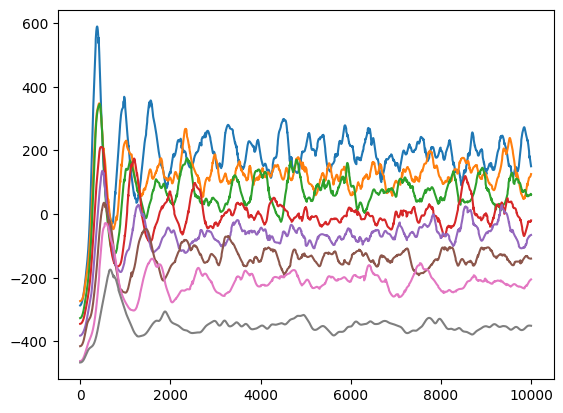

In [17]:
####make scan over temperatures:(start with the biggest, save only the last iterations to account for relaxation time)
Temps = np.arange(2.0, 0.5, -0.2)
Es_history_T = np.zeros((steps, len(Temps)), dtype=np.float32) 
for i, Temp in enumerate(Temps):
    Es_T, distances_T, V_T, Pos_history_T, K_T = simulate(Ncube, Temp, M, steps, h)
    plt.plot(np.arange(0, steps, 1, dtype=int), Es + K)
    Es_history_T[:, i] = Es_T
''' 
Temps = np.arange(2.0, 0.5, -0.2)
#print(Temps)
Es_history= np.zeros((steps, len(Temps)), dtype=np.float32) 
for Temp in Temps:
    Es, distances, V, Pos_history, K = simulate(Ncube, Temp, M, steps, h)
    plt.plot(np.arange(0, steps, 1, dtype=int), Es+K)
    #Es_history[Temp] = Es'''

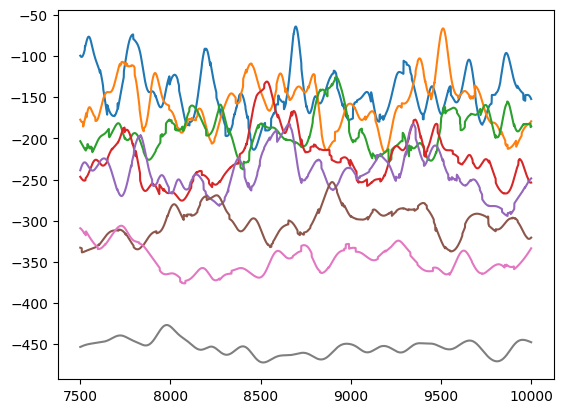

In [32]:
upperbond= steps
downwardbond= int((3/4)*steps)
for i in range(len(Temps)):
    plt.plot(np.arange( downwardbond, upperbond, 1, dtype=int), Es_history_T[downwardbond:upperbond, i])

In [ ]:
###Try to get relaxation time: THEN I WOULD HAVE TO HAVE E,K etc... as an input!!!
Es_history_e = np.zeros((steps, len(Temps)), dtype=np.float32) 
for i, Temp in enumerate(Temps):
    Es_e, distances__e, V_e, Pos_history_e, K_e = simulate(Ncube, Temp, M, steps, h)
    plt.plot(np.arange(0, steps, 1, dtype=int), Es_e + K_e)
    Es_history_e[:, i] = Es_e

In [14]:
K
print(len(K), len(Es))

10000 10000


In [ ]:
print(simbox)
#### time stuff!

[4.762203 4.762203 4.762203]


10000 10000


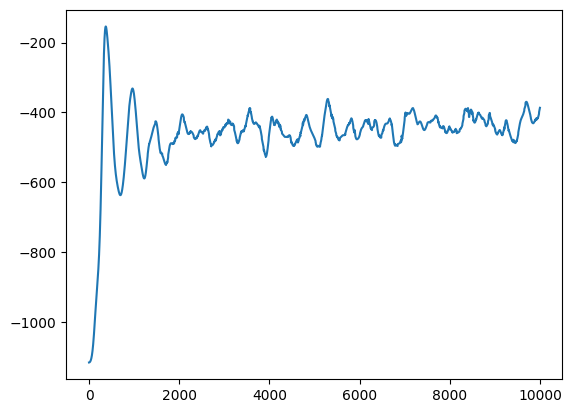

In [ ]:
TotalE = K + Es
print(len(K), len(Es))
plt.plot(np.arange(0, steps, 1, dtype=int),TotalE)
#plt.ylim(-560, -580)
VarE = np.var(TotalE) ###get the variance in a numpy array (maybe in relation to the average!!!)

[-654.42982362 -654.42246558 -654.40852123 ...   72.82101048   73.53445587
   74.25552131]


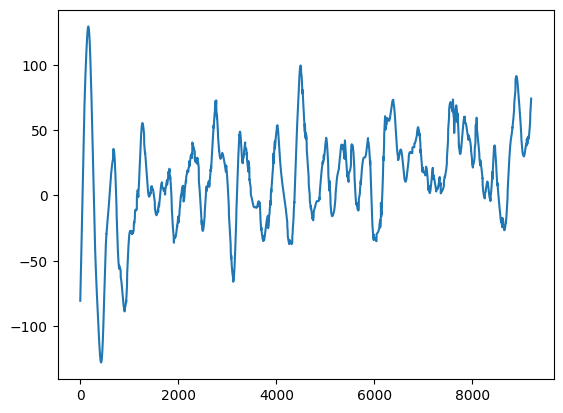

In [ ]:
VarE2=TotalE-np.mean(TotalE)
print(TotalE-np.mean(TotalE))
plt.plot(VarE2[800:])

10000 256


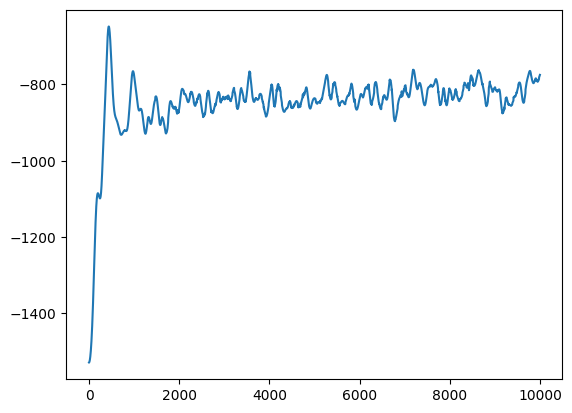

In [ ]:
plt.plot(Es)
#plt.ylim(0,1000)
#plt.xlim(1,1.19)
print(len(distances), len(V))

###Try to plot the particles
#####calculate kineticb energy and see if total is contant

4.762203


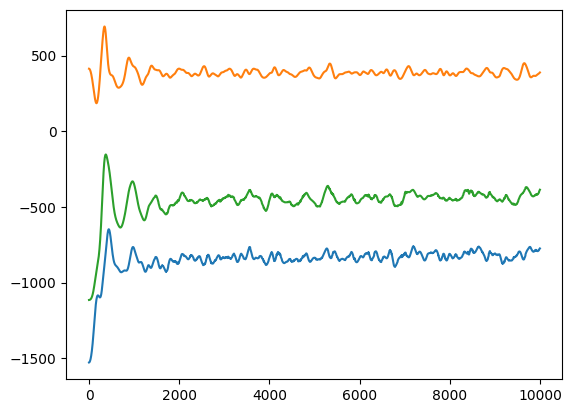

In [ ]:

###plot of energies
plt.plot(Es)
plt.plot(K)
plt.plot(K+Es)
#print(type(K))
#print(K+Es)
print(simbox[0])
#plt.ylim(-1250,-900)

In [ ]:
Es

array([-1528.44707781, -1528.39164297, -1528.30097246, ...,
        -775.7343525 ,  -775.30384537,  -774.85733458])

C:\Users\35196\AppData\Local\Temp\ipykernel_11968\3742093442.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, s=100, c=c) #, alpha = t/steps


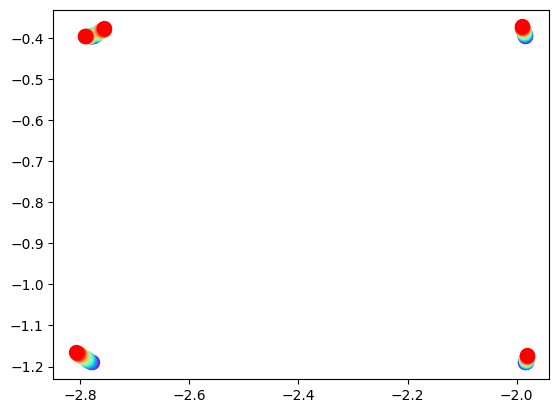

10000

In [ ]:
###see particles
n_colours = 30
colour = iter(cm.rainbow(np.linspace(0, 1, n_colours)))
for t in range(0,n_colours): ##number of steps
    c = next(colour)
    for i in range(5): ###number of particles
        x = Pos_history[t][i][0]  # x-coordinate
        y = Pos_history[t][i][1]  # y-coordinate   
        #plt.scatter(x, y, s=100,c ='green', alpha = t/steps)  # Plot point with specified size and color
        plt.scatter(x, y, s=100, c=c) #, alpha = t/steps
plt.show()
len(Pos_history)